In [1]:
import os
import pickle
import numpy as np
import custom_tools
import pandas as pd
import seaborn as sns
import sksurv.util as su
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from sksurv.svm import FastSurvivalSVM
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from custom_tools import create_hyperparameter_combinations
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from baseline_hyperparams import FastSurvivalSVM_params, RandomSurvivalForest_params, GradientBoostingSurvivalAnalysis_params

structured array with the first field indicating whether the actual survival time was observed or if was censored, and the second field denoting the observed survival time, which corresponds to the time of death (if Status == 'dead', then status=1) or the last time that person was contacted (if Status == 'alive', status = 0 ).



In [2]:
def get_dataset_df(dataset_path, agg="mean"):
    wanted_label = "OSmonth"
    unit = "month"
    count = 0
    columns = []
    data_list = []
    for fl in os.listdir(os.path.join(dataset_path, "raw")):
        if fl.endswith("features.pickle"):
            # print(fl)
            img, pid = fl.split("_")[:2]
            with open(os.path.join(dataset_path, "raw", f'{img}_{pid}_clinical_info.pickle'), 'rb') as handle:
                clinical_info_dict = pickle.load(handle)
            if pd.notna(clinical_info_dict["OSmonth"]):
                censored = None

                if "Patientstatus" in clinical_info_dict.keys():
                    censored = 0 if clinical_info_dict["Patientstatus"].lower().startswith("death") else 1
                elif "Overall Survival Status" in clinical_info_dict.keys():
                    censored = 0 if "deceased" in clinical_info_dict["Overall Survival Status"].lower() else 1

                with open(os.path.join(dataset_path, "raw", f'{img}_{pid}_features.pickle'), 'rb') as handle:
                    feature_arr = pickle.load(handle)
                    feature_arr = np.array(feature_arr)
                    if agg=="mean":
                        feature_arr = feature_arr.mean(axis=0)
                    elif agg=="sum":
                        feature_arr = feature_arr.sum(axis=0)
                    elif agg=="min":
                        feature_arr = feature_arr.min(axis=0)
                    elif agg=="max":
                        feature_arr = feature_arr.max(axis=0)

                row = feature_arr.copy()
                y_val = clinical_info_dict["OSmonth"]

                lst_clinical_info = clinical_info_dict.keys()
                lst_clinical_info = sorted(lst_clinical_info)

                if len(columns)==0:
                    for i in range(len(feature_arr)):
                        columns.append(f"Marker_{i}")
                    for ci in lst_clinical_info:
                        columns.append(ci)
                    columns.append("img_id")
                    columns.append("p_id")



                for key in lst_clinical_info:
                    row = np.append(row, clinical_info_dict[key])

                row = np.append(row, img)
                row = np.append(row, pid)

                data_list.append(row)
                # print(feature_arr)
                count+=1

    df_features = pd.DataFrame(data_list, columns=columns)
    return df_features

In [3]:


dataset_name = "METABRIC"
dataset_name = "JacksonFischer"

dataset_path = os.path.join("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data", dataset_name)
gene_lst = custom_tools.get_gene_list(dataset_name=dataset_name)

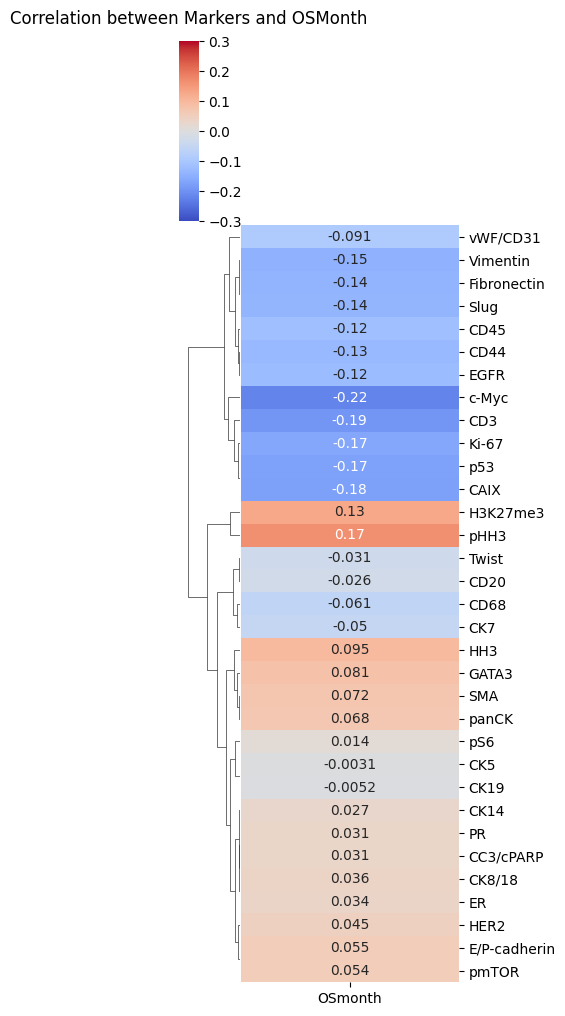

In [6]:


df_dataset = get_dataset_df(dataset_path=dataset_path, agg="mean")
# df_dataset = df_dataset[df_dataset["clinical_type"]=="HR+HER2-"]
marker_columns = [col for col in df_dataset.columns if col.startswith("Marker")]

marker_lst = custom_tools.get_gene_list(dataset_name)
mapping_dict = dict()
for ind, dm in enumerate(marker_columns):
    mapping_dict[dm] = marker_lst[ind]

# call rename () method
df_dataset.rename(columns=mapping_dict,
          inplace=True)




for mar in marker_lst:
    df_dataset[mar] = df_dataset[mar].astype("float")

df_dataset["OSmonth"]  =  df_dataset["OSmonth"].astype("float")

# Load your dataframe (replace this with your actual dataframe)
# df = pd.read_csv("your_file.csv")

# Filter the columns that start with "Marker" and "OSMonth"
marker_columns = [col for col in df_dataset.columns if col.startswith("Marker")]
target_column = "OSmonth"

# Standardize the "Marker" columns and "OSMonth" if necessary
# df_dataset[marker_lst + [target_column]] = df_dataset[marker_lst + [target_column]].apply(lambda x: (x - x.mean()) / x.std())

# Calculate correlations
correlations = {}
for marker in marker_lst:
    correlation, _ = pearsonr(np.log(df_dataset[marker]+1), df_dataset[target_column])
    correlations[marker] = correlation

# Calculate correlations and prepare a DataFrame for plotting
correlations = df_dataset[marker_lst + [target_column]].corr()[target_column].drop(target_column)
correlation_df = correlations.to_frame()

"""# Plot the cluster map
sns.clustermap(correlation_df, cmap="coolwarm", annot=True,  vmin=-0.5, vmax=0.5, figsize=(20, 1), col_cluster=True, row_cluster=False)
plt.title("Correlation between Markers and OSMonth")
plt.show()
"""

# Plot the cluster map with a vertical layout and limited color scale
sns.clustermap(correlation_df, cmap="coolwarm", annot=True, vmin=-0.3, vmax=0.3, figsize=(4, 10), col_cluster=False, row_cluster=True)
plt.title("Correlation between Markers and OSMonth", y=1.05)
plt.savefig(os.path.join("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/", dataset_name, "corr_between_abun_surv.pdf"), dpi=300)
plt.show()

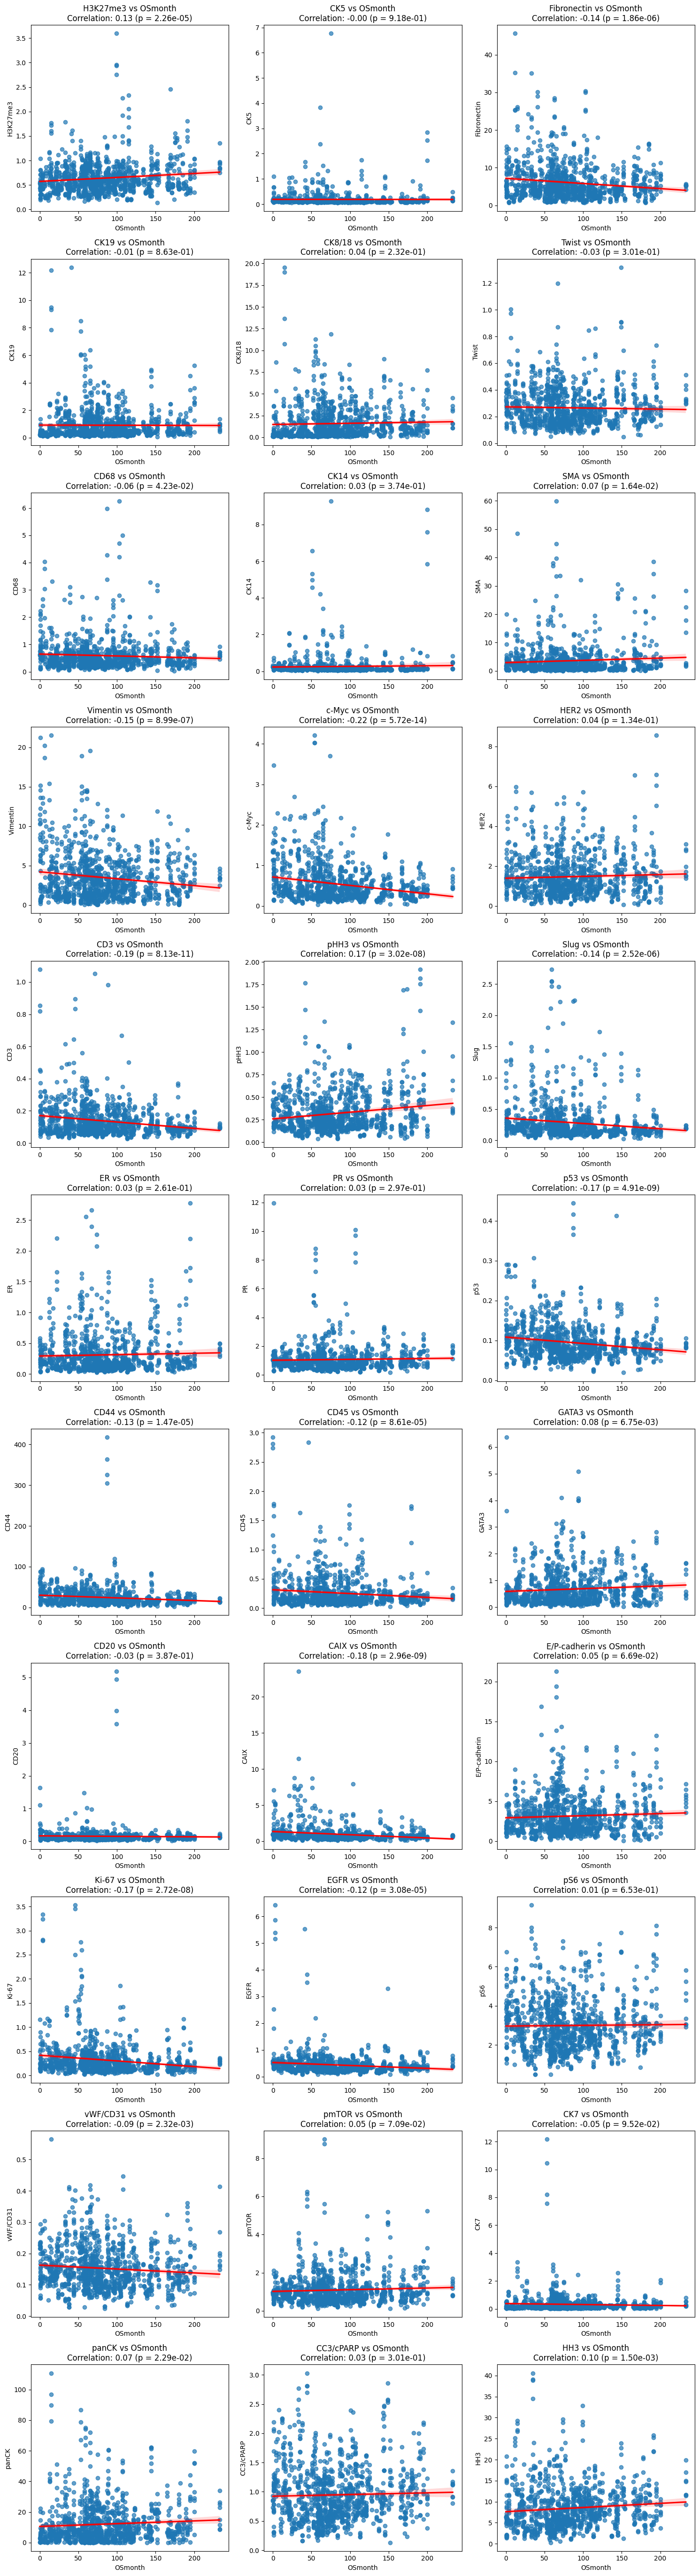

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load your dataframe (replace this with your actual dataframe)
# df = pd.read_csv("your_file.csv")

# Filter the columns that start with "Marker" and "OSMonth"
marker_columns = [col for col in df_dataset.columns if col.startswith("Marker")]
target_column = "OSmonth"

# Create a grid of scatter plots with correlation values
num_markers = len(marker_lst)
n_cols = 3  # Number of columns in the plot grid
n_rows = (num_markers + n_cols - 1) // n_cols  # Calculate number of rows

plt.figure(figsize=(15, n_rows * 5))

for i, marker in enumerate(marker_lst, 1):
    # Calculate correlation
    correlation, p_value = pearsonr(df_dataset[marker], df_dataset[target_column])

    # Create scatter plot with regression line
    plt.subplot(n_rows, n_cols, i)
    sns.regplot(x=df_dataset[target_column], y=df_dataset[marker], scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
    plt.title(f"{marker} vs {target_column}\nCorrelation: {correlation:.2f} (p = {p_value:.2e})")
    plt.xlabel(target_column)
    plt.ylabel(marker)

plt.tight_layout()
plt.savefig(os.path.join("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/", dataset_name, "scatter_corr_between_abun_surv.pdf"), dpi=300)
plt.show()
# plt.show()


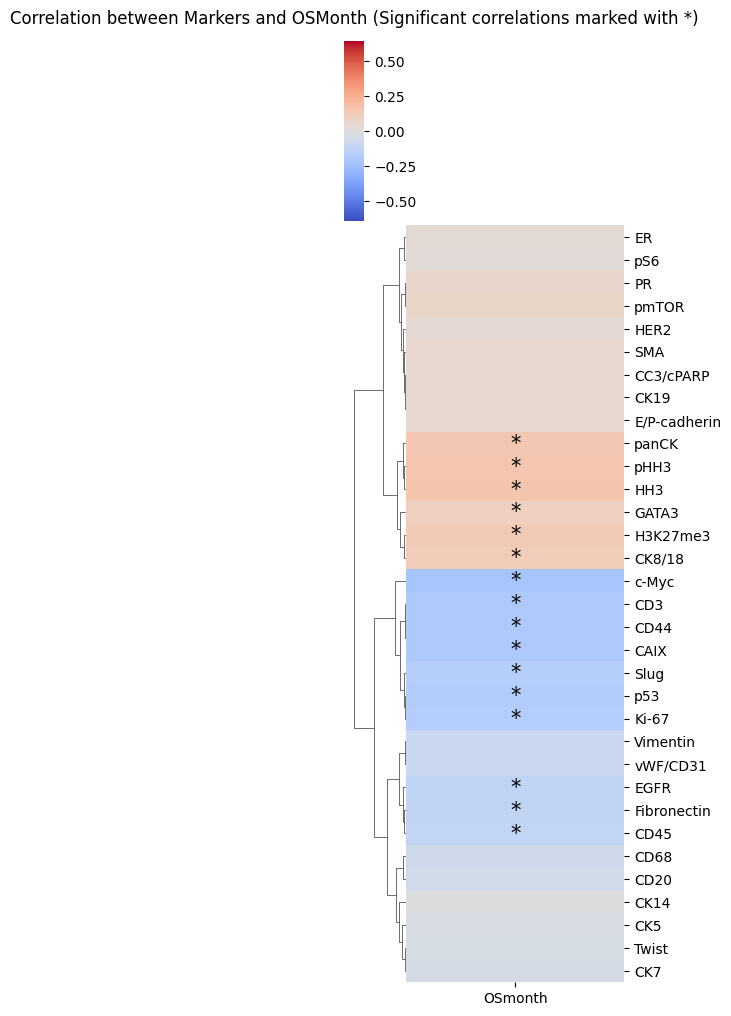

In [7]:

target_column = "OSmonth"

df_dataset = get_dataset_df(dataset_path=dataset_path, agg="mean")
marker_columns = [col for col in df_dataset.columns if col.startswith("Marker")]

marker_lst = custom_tools.get_gene_list(dataset_name)
mapping_dict = dict()
for ind, dm in enumerate(marker_columns):
    mapping_dict[dm] = marker_lst[ind]

# call rename () method
df_dataset.rename(columns=mapping_dict,
          inplace=True)

for mar in marker_lst:
    df_dataset[mar] = df_dataset[mar].astype("float")

df_dataset[target_column]  =  df_dataset[target_column].astype("float")

# Calculate correlations
correlations = []
p_values = []
for marker in marker_lst:
    correlation, p_value = pearsonr(np.log(df_dataset[marker]+1), df_dataset[target_column])
    correlations.append(correlation)
    p_values.append(p_value)







correlation_df = pd.DataFrame(correlations, index=marker_lst, columns=[target_column])

# Create a DataFrame for annotations with stars for significance
annotations = pd.DataFrame(data=np.full(correlation_df.shape, '', dtype=object), index=correlation_df.index, columns=correlation_df.columns)
for i, p_value in enumerate(p_values):
    if p_value < 0.001:  # Set significance threshold
        annotations.iloc[i, 0] = '*'  # Add a star if correlation is significant

# Plot the cluster map with annotations for significant correlations
sns.clustermap(correlation_df, cmap="coolwarm", annot=annotations, fmt="", annot_kws={"size": 15, "color": "black"}, vmin=-0.64, vmax=0.64, figsize=(4, 10), col_cluster=False, row_cluster=True)
plt.title("Correlation between Markers and OSMonth (Significant correlations marked with *)", y=1.05)
plt.show()


In [3]:
def load_json(file_path):
    """Loads the json file for given path

    Args:
        file_path (string): file path

    Returns:
        dict: dict of the json
    """
    
    with open(file_path, 'r') as fp:
        l_dict = json.load(fp)
    return l_dict

import json
json_fl = load_json("/home/rifaioglu/projects/GNNClinicalOutcomePrediction/data/JacksonFischer/folds.json")

In [4]:
json_fl

{'fold_img_id_dict': {'fold_0': [['191ll',
    '198ll',
    '40ur',
    '131ll',
    '42',
    '204ll',
    '256ll',
    '122ul',
    '12ll',
    '372ll',
    '27lr',
    '270lr',
    '331ur',
    '326ur',
    '158ul',
    '118ll',
    '149ul',
    '197ur',
    '306ul',
    '75ur',
    '98ul',
    '315ur',
    '300ll',
    '324ur',
    '43ul',
    '290ur',
    '158ur',
    '286ul',
    '348lr',
    '278ll',
    '161ll',
    '258lr',
    '346ur',
    '278lr',
    '218ll',
    '276',
    '31ll',
    '125ur',
    '188ll',
    '354lr',
    '206ur',
    '126ul',
    '266lr',
    '356ll',
    '274lr',
    '145ul',
    '222ur',
    '115ur',
    '69ll',
    '72lr',
    '82ll',
    '294ul',
    '44ur',
    '78ul',
    '313ur',
    '221ur',
    '55ur',
    '134lr',
    '206lr',
    '100ur',
    '256ur',
    '269lr',
    '82ur',
    '346ul',
    '43ur',
    '110lr',
    '186ll',
    '162ll',
    '194ur',
    '105ul',
    '89ul',
    '301lr',
    '298ll',
    '244',
    '228lr',
    '285ur',
    '

In [8]:
aggregator = ["sum", "mean", "min", "max"]
estimators = ["FastSurvivalSVM", "RandomSurvivalForest", "GradientBoostingSurvivalAnalysis"]

hyper_param_combs_dict = {"FastSurvivalSVM":create_hyperparameter_combinations(FastSurvivalSVM_params), "RandomSurvivalForest":create_hyperparameter_combinations(RandomSurvivalForest_params), "GradientBoostingSurvivalAnalysis":create_hyperparameter_combinations(GradientBoostingSurvivalAnalysis_params)}

result_df_cols  = []
all_results = []
for agg in aggregator:
    df_dataset = get_dataset_df(agg=agg)
    all_data_y =[]
    all_status = []
    for ind, row in df_dataset.iterrows():
        patient_status = True if row["Patientstatus"].lower().startswith("death") else False
        all_data_y.append((patient_status, float(row["OSmonth"])))
        all_status.append(patient_status)

    df_dataset["data_y"] = all_data_y
    df_dataset["status"] = all_status
    # print(df_dataset)

    # List to save sampler triplet
    samplers = []

    for fold in json_fl["fold_img_id_dict"]:
        train_idx = list(df_dataset.loc[df_dataset.img_id.isin(json_fl["fold_img_id_dict"][fold][0]),:].index)
        test_idx = list(df_dataset.loc[df_dataset.img_id.isin(json_fl["fold_img_id_dict"][fold][1]),:].index)

        samplers.append((
                (fold), # fold number
                (train_idx),
                (test_idx)))
    
    for est_name in estimators:
        hyper_param_combs = hyper_param_combs_dict[est_name]
        for ind, comb in enumerate(hyper_param_combs):
            result_df_cols.append(f"{est_name}-{ind}-{agg}")
            estimator = None
            if est_name == "FastSurvivalSVM":
                estimator = FastSurvivalSVM(**comb)
            elif est_name == "RandomSurvivalForest":
                estimator = RandomSurvivalForest(**comb)
            elif est_name == "GradientBoostingSurvivalAnalysis":
                estimator = GradientBoostingSurvivalAnalysis(**comb)
            else:
                raise Exception("Please enter a valid estimator...")
            
            k_fold_cindex = []
            for fold_id, train_idx, test_idx in samplers:
                train_df = df_dataset.iloc[train_idx]
                data_x = train_df.iloc[:,:33]
                data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))

                test_df = df_dataset.iloc[test_idx]
                test_data_x = test_df.iloc[:,:33]
                test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
                estimator.fit(data_x, data_y)

                test_cindex = concordance_index_censored(
                test_df["status"],
                test_df["OSmonth"],
                estimator.predict(test_data_x))
                k_fold_cindex.append(test_cindex[0])
            all_results.append(k_fold_cindex)
            print(ind)
            if ind==2:
                break
            # print(f"{est_name}\t{ind}\t{agg}:", round(sum(k_fold_cindex)/len(k_fold_cindex),2))

print(len(all_results))
print(len(result_df_cols))
df_results = pd.DataFrame(np.array(all_results).T, columns=result_df_cols)

df_results.to_csv("pseudobulk_results.csv")

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
36
36


In [ ]:
k_fold_cindex = []
for fold_id, train_idx, test_idx in samplers:
    estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
    train_df = df_dataset.iloc[train_idx]
    data_x = train_df.iloc[:,:33]
    data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))
    
    test_df = df_dataset.iloc[test_idx]
    test_data_x = test_df.iloc[:,:33]
    test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
    estimator.fit(data_x, data_y)
    
    test_cindex = concordance_index_censored(
    test_df["status"],
    test_df["OSmonth"],
    estimator.predict(test_data_x))
    k_fold_cindex.append(test_cindex[0])

print(sum(k_fold_cindex)/len(k_fold_cindex))

In [ ]:
k_fold_cindex = []
scores = []
for fold_id, train_idx, test_idx in samplers:
    estimator = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1)
    train_df = df_dataset.iloc[train_idx]
    data_x = train_df.iloc[:,:33]
    data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))
    
    test_df = df_dataset.iloc[test_idx]
    test_data_x = test_df.iloc[:,:33]
    test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
    estimator.fit(data_x, data_y)
    
    test_cindex = concordance_index_censored(
    test_df["status"],
    test_df["OSmonth"],
    estimator.predict(test_data_x))
    
    k_fold_cindex.append(test_cindex[0])

print(sum(k_fold_cindex)/len(k_fold_cindex))

In [ ]:
df_dataset = get_dataset_df(agg="mean")

all_data_y =[]
all_status = []
for ind, row in df_dataset.iterrows():
    patient_status = True if row["Patientstatus"].lower().startswith("death") else False
    all_data_y.append((patient_status, float(row["OSmonth"])))
    all_status.append(patient_status)
    
df_dataset["data_y"] = all_data_y
df_dataset["status"] = all_status

In [ ]:
k_fold_cindex = []
for fold_id, train_idx, test_idx in samplers:
    estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
    train_df = df_dataset.iloc[train_idx]
    data_x = train_df.iloc[:,:33]
    data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))
    
    test_df = df_dataset.iloc[test_idx]
    test_data_x = test_df.iloc[:,:33]
    test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
    estimator.fit(data_x, data_y)
    
    test_cindex = concordance_index_censored(
    test_df["status"],
    test_df["OSmonth"],
    estimator.predict(test_data_x))
    k_fold_cindex.append(test_cindex[0])

print(sum(k_fold_cindex)/len(k_fold_cindex))

In [ ]:
k_fold_cindex = []
scores = []
for fold_id, train_idx, test_idx in samplers:
    estimator = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1)
    train_df = df_dataset.iloc[train_idx]
    data_x = train_df.iloc[:,:33]
    data_y = su.Surv.from_arrays(train_df["status"], train_df["OSmonth"].astype("float").add(0.1))
    
    test_df = df_dataset.iloc[test_idx]
    test_data_x = test_df.iloc[:,:33]
    test_data_y = su.Surv.from_arrays(test_df["status"], test_df["OSmonth"].astype("float").add(0.1))
    estimator.fit(data_x, data_y)
    
    test_cindex = concordance_index_censored(
    test_df["status"],
    test_df["OSmonth"],
    estimator.predict(test_data_x))
    
    k_fold_cindex.append(test_cindex[0])

print(sum(k_fold_cindex)/len(k_fold_cindex))
